# Assingment 2 - Contrast transfer
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

For the second assignment we will use the same dataset as before! Previously you have classified the available contrasts of the same anatomy, and for this assignment you will train an image to image model to generate one contrast from another. The task is to take T1-weighted images as inputs, and generate the corresponding T2-weighted images.

Your tasks, to include in the Jupyter notebook you hand in, are:
- Reach a validation MSE below 0.015 on the validation set, and describe what parameter combinations you have gone through to reach those results.
- Describe the effect of each hyper-parameter you have changed, and the way you have experimented with them. What problems did you face? What happened when the training failed? Try describing everything that you have learnt.
- Answer the questions set in notes

Upload the updated notebook to canvas, that also contains your answers to the questions above. The deadline for the assignment is March $30^{th}$, 15:00.

Good luck and have fun!

In [1]:
import os
import numpy as np
np.random.seed(2023)  # Set seed for reproducibility
import tensorflow as tf
import tensorflow.keras as keras
tf.random.set_seed(2026) # Note: Different to test different initializations.
!pip install tqdm # Adding tqdm to use progress bars. Unbarable waiting for each epoch to finish without feedback.
from tqdm import tqdm

2023-03-21 17:59:24.881376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 17:59:25.910056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-03-21 17:59:25.910114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/theodor/anaconda3/envs/tf/lib/
2023-03-21 17:59:25.910120: W tensorflow/compiler/tf2t

In [2]:
# Using ImageGrid to plot the encodings.
from mpl_toolkits.axes_grid1 import ImageGrid
from typing import List

In [3]:
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from keras.utils import to_categorical
from keras.utils import img_to_array
from keras.utils import load_img
from keras.utils import to_categorical

# Using ImageGrid to plot the encodings.
from mpl_toolkits.axes_grid1 import ImageGrid
from typing import List

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


2023-03-21 17:59:29.934192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 17:59:29.958212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 17:59:29.958501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x / np.max(x)

        return arrays

# NOTE: Don't change the data generator!

In [5]:
gen_dir = './data/' # Change if you have copied the data locally on your machine 
array_labels = ['t1', 't2']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
batch_size = 32

gen_train = DataGenerator(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? You can use multiple contrasts as inputs, if you'd like.
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

In [6]:
# imgs = gen_train[0]
# for inp in range(np.shape(imgs)[0]):
#     plt.figure(figsize=(12,5))
#     for i in range(4):
#         plt.subplot(1, 4, i + 1)
#         plt.imshow(imgs[inp][i, :, :, 0], cmap='gray')
#         plt.colorbar()
#         plt.title('Image size: ' + str(np.shape(imgs[inp][i, :, :, 0])))
#         plt.tight_layout()
#     plt.suptitle('Array: ' + gen_train.arrays[inp])
#     plt.show()


In [7]:
def plot_sample(x:np.ndarray,y:np.ndarray,n:int=3,title:str='Sample of inputs and labels'):
    """Plot a sample of the images and masks."""
    fig, ax = plt.subplots(2, n, figsize=(12, 5))
    for i in range(n):
        ax[0, i].imshow(x[i, :, :, 0], cmap='gray')
        ax[0, i].set_title('T1')
        ax[1, i].imshow(y[i, :, :, 0], cmap='gray')
        ax[1, i].set_title('T2')
        # Colorbar
        fig.colorbar(ax[0, i].imshow(x[i, :, :, 0], cmap='gray'), ax=ax[0, i])
        fig.colorbar(ax[1, i].imshow(y[i, :, :, 0], cmap='gray'), ax=ax[1, i])
    # Increase spacing between subplots vertically
    # fig.subplots_adjust(hspace=0.3)
    # fig.subplots_adjust(wspace=0.01)
    # fig.text(0.15, 0.75, 'Input - T1', va='center', rotation='vertical')
    # fig.text(0.15, 0.25, 'Label - T2', va='center', rotation='vertical')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    # Add label to the left of the figure
# %matplotlib inline
# x,y = gen_train[0]
# plot_sample(x,y,4)
    

In [8]:
# A quick summary of the data:
print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")

Number of training images : 8000
Training batch size       : [(32, 256, 256, 1), (32, 256, 256, 1)]


In [9]:
# Import packages important for building and training your model.
# import keras
from keras import backend as K
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, Conv2D
from keras.layers import Flatten, Input
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, concatenate
from keras.layers import BatchNormalization
from keras.layers import Dropout, UpSampling2D
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, Nadam

In [10]:

from tensorflow import Tensor
from keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                        Add, AveragePooling2D, Flatten, Dense, UpSampling2D
from keras.models import Model

def build_model():
    filt_size = 8
    # input1 = Input(shape=(128, 128, 1))
    input1 = Input(shape=(256, 256, 1))

    conv1 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input1)
    conv1 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(filt_size * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal',name="bottle_neck1")(pool4)
    conv5 = Conv2D(filt_size * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal',name="bottle_neck2")(conv5)
    drop5 = Dropout(0.5)(conv5)
    skip46 = Conv2D(filt_size * 8, 1, activation='relu', padding='same', kernel_initializer='he_normal',name="skip4-6")(conv4)
    up6 = Conv2D(filt_size * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6) + skip46
    conv6 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    skip37 = Conv2D(filt_size * 4, 1, activation='relu', padding='same', kernel_initializer='he_normal',name="skip3-7")(conv3)
    up7 = Conv2D(filt_size * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7) + skip37
    conv7 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    skip28 = Conv2D(filt_size * 2, 1, activation='relu', padding='same', kernel_initializer='he_normal',name="skip2-8")(conv2)
    up8 = Conv2D(filt_size * 2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8) + skip28
    conv8 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    skip19 = Conv2D(filt_size, 1, activation='relu', padding='same', kernel_initializer='he_normal',name="skip1-9")(conv1)
    up9 = Conv2D(filt_size, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9) + skip19
    conv9 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation="sigmoid",name="prediction")(conv9)

    return Model(inputs=input1, outputs=conv10)

In [11]:
# Model parameters
from archs.segmentation.unet import build_unet
W,H,C = 256,256,1
input_shape = (W,H,C)
num_classes = C # Number of classes is equal to the number of channels in the output
filters = [8,16,32,64,128,256,512,1024]
kernel_size = [3,3,3,3,3,3,3,1]
strides = 1
padding = "same"
activation = "selu"
# drop_rate_encoder = [0.01,0.02,0.02,0.1]
# drop_rate_decoder = [0.01,0.1,0.1,0]
drop_rate_encoder = [0.0,0.02,0.02,0.05]
drop_rate_decoder = [0.0]
depth_encoder = [2,2,3,4,4,5,6,8]
depth_decoder = [1,1,1,1,1,1,1,1]
output_depth = 1
output_activation = "sigmoid"

model = build_unet(
    input_shape=input_shape,
    num_classes=num_classes,
    filters=filters,
    kernel_size=kernel_size,
    strides=strides,
    padding=padding,
    activation=activation,
    depth_encoder=depth_encoder,
    depth_decoder=depth_decoder,
    drop_rate_encoder=drop_rate_encoder,
    drop_rate_decoder=drop_rate_decoder,
    output_depth=output_depth,
    output_activation=output_activation,
)
model.summary()

2023-03-21 16:12:01.123536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 16:12:01.123972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 16:12:01.124339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 16:12:01.124831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 Encoder (Functional)           [(None, 128, 128, 8  51245936    ['input_2[0][0]']                
                                ),                                                                
                                 (None, 64, 64, 16)                                               
                                , (None, 32, 32, 32                                               
                                ),                                                            

In [38]:
# model.layers[1] = encoder
# model.layers[1].trainable = False

In [15]:
# Build your model.
# model = build_model()
# model.summary()

# NOTE: Are the input sizes correct?
# NOTE: Do you have the correct number of input images?
# NOTE: Are the output sizes correct?
# NOTE: Do you have the correct number of output images?
# NOTE: What's the range of the output? Can you use an activation as a regularizer?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are your parameters split evenly inside the model? Try making "too large" layers smaller
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

In [13]:
# Augmentation class for used in the training pipeline.
# float wrapper for probability
def prob(p: float) -> bool:
    return np.random.random() < p
class Augmentation:
    verbose: bool = False
    # Parent class for all augmentations
    def __init__(self, p: float):
        self.p = p
    @property
    def name(self) -> str:
        return self.__class__.__name__
    def __call__(self, x: np.ndarray,y: np.ndarray) -> np.ndarray:
        if prob(self.p):
            if self.verbose:
                print(f"Augmenting: Applying {self.name}")
            return self.augment(x,y)
        else:
            return x,y
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        raise NotImplementedError
    

class Flip(Augmentation):
    def __init__(self, p: float = 0.5, axis: int = 0):
        super().__init__(p)
        self.axis = axis # 1 for horizontal, 0 for vertical
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        return np.flip(x, axis=self.axis),np.flip(y, axis=self.axis)

class Rotate(Augmentation):
    def __init__(self, p: float = 0.5, angle: float = np.pi/4):
        super().__init__(p)
        self.angle = angle
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Rotate image and fill with zeros
        # Random angle between -angle and angle
        angle = np.random.uniform(-self.angle, self.angle)
        # return rotate(x, angle, resize=False, mode="constant", cval=0),rotate(y, angle, resize=False, mode="constant", cval=0)
        # Batched rotate
        return np.array([rotate(img, angle, resize=False, mode="constant", cval=0) for img in x]),np.array([rotate(img, angle, resize=False, mode="constant", cval=0) for img in y])
class Noise(Augmentation):
    def __init__(self, p: float = 0.5, mean: float = 0.0, std: float = 0.1):
        super().__init__(p)
        self.mean = mean
        self.std = std
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        noise = np.random.normal(self.mean, self.std, x.shape)
        return (x + noise, y)

class Mask(Augmentation):
    def __init__(self, p: float = 0.5, max_n_masks: int = 10, mask_size: float = 0.5):
        super().__init__(p)
        self.max_n_masks = max_n_masks
        self.mask_size = mask_size
    def augment(self, x: np.ndarray, y:np.ndarray) -> np.ndarray:
        # Random number of masks
        n_masks = np.random.randint(1, self.max_n_masks)
        w = x.shape[-3]
        h = x.shape[-2]
        for _ in range(n_masks):
            # Random mask size
            mask_size = np.random.uniform(low=self.mask_size/2, high=self.mask_size)
            # Random mask position
            x1 = np.random.randint(0, w)
            y1 = np.random.randint(0, h)
            x2 = int(x1 + w * mask_size)
            y2 = int(y1 + h * mask_size)
            x[:, x1:x2, y1:y2,:] = 0
        return (x, y)

class Translate(Augmentation):
    def __init__(self, p: float = 0.5, factor: float = 0.5):
        super().__init__(p)
        self.factor = factor
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Random translation factor
        tx = np.random.uniform(-self.factor, self.factor) * x.shape[0]
        ty = np.random.uniform(-self.factor, self.factor) * x.shape[1]
        # Affine transform, grayscale image so no need to transform channels
        tform = AffineTransform(translation=(tx, ty))
        # Apply transform, Image will be filled with zeros
        # x = warp(x, tform.inverse, mode="constant", cval=0)
        # y = warp(y, tform.inverse, mode="constant", cval=0)
        # Batched warp
        x = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in x])
        y = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in y])
        return x,y

class Shear(Augmentation):
    def __init__(self, p: float = 0.5, factor: float = 0.5):
        super().__init__(p)
        self.factor = factor
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Random shear factor
        shear_factor = np.random.uniform(-self.factor, self.factor)
        # Create affine transform
        tform = AffineTransform(shear=shear_factor)
        # Use warp to apply transform
        # x = warp(x, tform.inverse, mode="constant", cval=0)
        # y = warp(y, tform.inverse, mode="constant", cval=0)
        # Batched warp
        x = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in x])
        y = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in y])
        return x,y
class Augmentor:
    """
    Augmentations:
    flip_x: float
        Probability of flipping the image horizontally
    flip_y: float
        Probability of flipping the image vertically
    rotate: float
        Probability of rotating the image
    radians: float
        Maximum rotation angle in radians
    translate: float
        Probability of translating the image
    noise: float
        Probability of adding noise to the image
    noise_std: float
        Standard deviation of the noise
    noise_mean: float
        Mean of the noise
    mask: float
        Probability of masking the image
    max_n_masks: int
        Maximum number of masks
    mask_size: float
        Maximum size of the mask as a fraction of the image size
    shear: float
        Probability of shearing the image
    shear_factor: float
        Maximum shear factor
    """
    def __init__(self,
                flip_x:float=0.25,
                flip_y:float=0.25,
                rotate:float=0.5,
                radians:float=np.pi/6,
                translate:float=0.2,
                noise:float=0.25,
                noise_std:float=0.1,
                noise_mean:float=0.1,
                mask:float=0.8,
                max_n_masks:int=10,
                mask_size:float=0.25,
                shear:float=0.1,
                shear_factor:float=0.4,
                verbose:bool=False
                ):
        self.verbose = verbose
        self._active = True
        Augmentation.verbose = self.verbose
        self.augmentations = {}
        if noise > 0:
            self.augmentations["noise"] = Noise(p=noise, std=noise_std, mean=noise_mean)
        if flip_x > 0:
            self.augmentations["flip_x"] = Flip(p=flip_x, axis=1)
            # self.augmentations.append(Flip(p=flip_x, axis=1))
        if flip_y > 0:
            self.augmentations["flip_y"] = Flip(p=flip_y, axis=0)
            # self.augmentations.append(Flip(p=flip_y, axis=0))
        if rotate > 0:
            self.augmentations["rotate"] = Rotate(p=rotate, angle=radians)
            # self.augmentations.append(Rotate(p=rotate, angle=radians))
        if translate > 0:
            self.augmentations["translate"] = Translate(p=translate, factor=translate)
            # self.augmentations.append(Translate(p=translate, factor=translate))
        if mask > 0:
            self.augmentations["mask"] = Mask(p=mask, max_n_masks=max_n_masks, mask_size=mask_size)
            # self.augmentations.append(Mask(p=mask, max_n_masks=max_n_masks, mask_size=mask_size))
        if shear > 0:
            self.augmentations.append(Shear(p=shear, factor=shear_factor))
    def __call__(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        if self._active:
            if x.shape != y.shape:
                raise Exception("x and y must have the same shape")
            if len(x.shape) < 4:
                x = x[np.newaxis,...]
                y = y[np.newaxis,...]
            for aug in self.augmentations.values():
                x,y = aug(x,y)
        return x, y
    @property
    def keys(self):
        return list(self.augmentations.keys())
    @property
    def active(self):
        return self._active
    def scale_probability(self, key:str, factor:float):
        if self.verbose:
            print(f"Scaling probability of {key} by {factor:3.3e}: {self.augmentations[key].p:3.3e} -> {self.augmentations[key].p * factor:3.3e}")
        self.augmentations[key].p *= factor
    def set_active(self, active:bool):
        self._active = active
    def __repr__(self):
        return f"Augmentor({', '.join([f'{k}: {v.p:3.3e}' for k,v in self.augmentations.items()])})"
    

In [14]:
# Load model
def load_model(path):
    m = keras.models.load_model(path)
    print(m.summary())
    return m

In [15]:
## Original code.
# learning_rate = 0.01
# optim = optimizers.Adam(lr=learning_rate)
# model.compile(loss="mse",
#               optimizer=optim)
##


custom_lr = 0.001 #0.00005, Original. NOTE: I used 0.0005 for the first 50 Epochs.
weight_decay = 0.005 # Weight decay for regularization.
clipvalue = 2 # Clipvalue for regularization.
augmentation_warmup = 0 # Warmup augmentations. How many epochs to train without augmentations.
# NOTE: Might need to replace the keyword "learning_rate" with "lr" since i used an newer version of Keras, see code below.
optim = Adam(learning_rate=custom_lr,decay=weight_decay,clipvalue=clipvalue)
# custom_optimizer = Adam(lr=custom_lr,decay=weight_decay) # Replaced RMSprop for Adam.
custom_loss = "mse" # MSE i used for regression. We'd like to predict categorically.
custom_metric = "mse"
augmentor = Augmentor(translate=0, # No translation. Due to lack of speed.
                      shear=0, # No shear. Due to lack of speed.
                      rotate=0, # No rotation. Due to lack of speed.
                      mask=0.8, # Probability of masking the image.
                      mask_size=0.2, # Maximum size of the mask as a fraction of the image size.
                      max_n_masks=8, # Maximum number of masks to apply.
                      noise=0.4, # Probability of adding Gaussian noise to the image.
                      noise_mean=0.05, # Mean of the noise.
                      noise_std=0.1, # Standard deviation of the noise.
                      ) # Augmentation of the data.
if augmentation_warmup > 0:
    augmentor.set_active(False)

model.compile(loss=custom_loss,
              optimizer=optim,
              metrics=[custom_metric])
name = "test_unet_bigbig2"
# Create model directory.
if not os.path.exists("./models"):
    os.makedirs("./models")
model_dir = os.path.join("./models", name)
n_epochs = 50
# NOTE: Are you satisfied with the optimizer and its parameters?

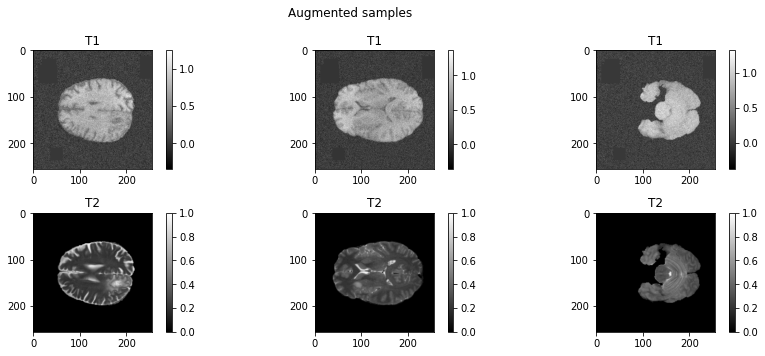

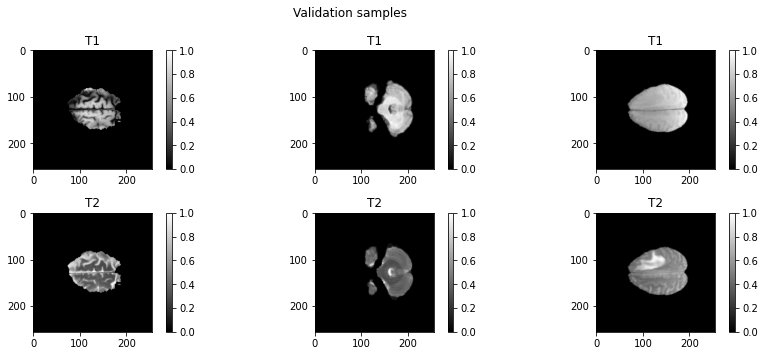

2023-03-21 16:12:54.890081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-21 16:12:55.909205: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-21 16:12:57.127489: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-03-21 16:12:57.631174: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid O

1/1 [==============================] - 5s 5s/step


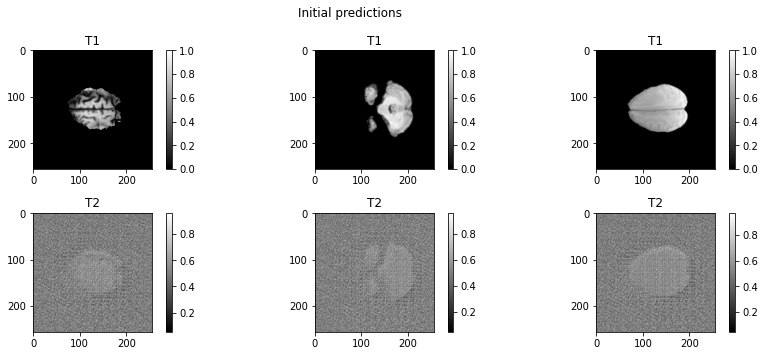

In [16]:

def plot():
    x_train, y_train = gen_train[0]
    x_train, y_train = augmentor(x_train,y_train)
    x_val, y_val = gen_val[0]
    plot_sample(x_train, y_train,title="Augmented samples")
    plot_sample(x_val, y_val,title="Validation samples")
    # Plot initial predictions.
    pred = model.predict(x_val)
    plot_sample(x_val, pred,title="Initial predictions")
plot()

In [17]:
best = np.inf
batches = len(gen_train)
total_batches = batches * n_epochs # Every batch is a training step.
# Define the history arrays for speed.
train_epoch_history = np.zeros(n_epochs)
valid_epoch_history = np.zeros(n_epochs)
train_batch_history = np.zeros(total_batches)
counter = 0
h = 0 # Initial loss for progress bar.

augmentation_start = batches*augmentation_warmup
print("Start training... This may take a while.")
for epoch in range(n_epochs):
    validating_loss = []
    pbar = tqdm(enumerate(gen_train)) # Progess bar to make it less boring, and trackable.
    for idx, (t1, t2) in pbar:
        t1, t2 = augmentor(t1,t2) # Augment the data.
        h = model.train_on_batch(t1, t2)[0]
        train_batch_history[counter] = h
        counter += 1
        if counter > augmentation_start and not augmentor.active:
            augmentor.set_active(True)
        if (idx+1)%10==0 or idx==0:
            pbar.set_description(f"Training Epoch {epoch+1}/{n_epochs}. {idx+1}/{batches} Batch. Training Loss MSE: {h:.3e}")
    for idx, (t1, t2) in enumerate(gen_val):
        validating_loss.append(model.test_on_batch(t1, t2)[0])
    train_epoch_history[epoch] = np.mean(train_batch_history[epoch*batches:(epoch+1)*batches])
    valid_epoch_history[epoch] = np.mean(validating_loss)
    if valid_epoch_history[epoch] < best:
        best = valid_epoch_history[epoch]
        model.save(model_dir)
    print(f"Epoch: {epoch + 1:2d}. Average loss - Training: {train_epoch_history[epoch]:.3e}, Validation: {valid_epoch_history[epoch]:.3e}")
# NOTE: Plotting the losses helps a lot.
# NOTE: What does plotting the training data tell you? Should you plot something else?
# NOTE: What should one do with the validation data? The data generator has a 'validation_data' argument as well.
# NOTE: When should one stop? Did you overtrain? Did you train for long enough?
# NOTE: Think abouct implementing Early Stopping?

Start training... This may take a while.


0it [00:00, ?it/s]2023-03-21 16:13:14.595477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/Encoder/residual_encoder_block_1/residual_block_1/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-21 16:13:15.607121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-21 16:13:16.150538: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-21 16:13:16.150564: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.37GiB with freed_by_count=0. The call

INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch:  1. Average loss - Training: 5.190e-02, Validation: 2.161e-02


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: invalid value encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 2/50. 250/250 Batch. Training Loss MSE: 6.205e-03: : 250it [01:22,  3.05it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch:  2. Average loss - Training: 8.319e-03, Validation: 6.735e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 3/50. 250/250 Batch. Training Loss MSE: 5.026e-03: : 250it [01:23,  3.00it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch:  3. Average loss - Training: 5.710e-03, Validation: 4.762e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 4/50. 250/250 Batch. Training Loss MSE: 4.448e-03: : 250it [01:21,  3.07it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch:  4. Average loss - Training: 5.017e-03, Validation: 4.383e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 5/50. 250/250 Batch. Training Loss MSE: 4.337e-03: : 250it [01:22,  3.03it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch:  5. Average loss - Training: 4.488e-03, Validation: 3.872e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 6/50. 250/250 Batch. Training Loss MSE: 4.483e-03: : 250it [01:20,  3.11it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch:  6. Average loss - Training: 4.121e-03, Validation: 3.595e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 7/50. 250/250 Batch. Training Loss MSE: 3.738e-03: : 250it [01:21,  3.05it/s]


Epoch:  7. Average loss - Training: 3.961e-03, Validation: 3.659e-03


Training Epoch 8/50. 250/250 Batch. Training Loss MSE: 3.237e-03: : 250it [01:19,  3.14it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch:  8. Average loss - Training: 3.673e-03, Validation: 3.428e-03


Training Epoch 9/50. 250/250 Batch. Training Loss MSE: 3.701e-03: : 250it [01:21,  3.07it/s]


Epoch:  9. Average loss - Training: 3.552e-03, Validation: 3.547e-03


Training Epoch 10/50. 250/250 Batch. Training Loss MSE: 2.831e-03: : 250it [01:20,  3.10it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 10. Average loss - Training: 3.416e-03, Validation: 3.309e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 11/50. 250/250 Batch. Training Loss MSE: 3.094e-03: : 250it [01:19,  3.13it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 11. Average loss - Training: 3.189e-03, Validation: 3.193e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 12/50. 250/250 Batch. Training Loss MSE: 3.625e-03: : 250it [01:21,  3.06it/s]


Epoch: 12. Average loss - Training: 3.041e-03, Validation: 3.616e-03


Training Epoch 13/50. 250/250 Batch. Training Loss MSE: 2.961e-03: : 250it [01:20,  3.10it/s]


Epoch: 13. Average loss - Training: 2.935e-03, Validation: 3.272e-03


Training Epoch 14/50. 250/250 Batch. Training Loss MSE: 2.535e-03: : 250it [01:20,  3.09it/s]


Epoch: 14. Average loss - Training: 2.957e-03, Validation: 3.326e-03


Training Epoch 15/50. 250/250 Batch. Training Loss MSE: 3.188e-03: : 250it [01:21,  3.08it/s]


Epoch: 15. Average loss - Training: 2.862e-03, Validation: 3.225e-03


Training Epoch 16/50. 250/250 Batch. Training Loss MSE: 2.513e-03: : 250it [01:20,  3.11it/s]


Epoch: 16. Average loss - Training: 2.728e-03, Validation: 3.310e-03


Training Epoch 17/50. 250/250 Batch. Training Loss MSE: 2.264e-03: : 250it [01:20,  3.11it/s]


Epoch: 17. Average loss - Training: 2.693e-03, Validation: 3.432e-03


Training Epoch 18/50. 250/250 Batch. Training Loss MSE: 2.559e-03: : 250it [01:20,  3.12it/s]


Epoch: 18. Average loss - Training: 2.678e-03, Validation: 3.309e-03


Training Epoch 19/50. 250/250 Batch. Training Loss MSE: 2.602e-03: : 250it [01:20,  3.12it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 19. Average loss - Training: 2.552e-03, Validation: 3.172e-03


Training Epoch 20/50. 250/250 Batch. Training Loss MSE: 2.421e-03: : 250it [01:21,  3.06it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 20. Average loss - Training: 2.552e-03, Validation: 3.059e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 21/50. 250/250 Batch. Training Loss MSE: 2.499e-03: : 250it [01:22,  3.04it/s]


Epoch: 21. Average loss - Training: 2.489e-03, Validation: 3.166e-03


Training Epoch 22/50. 250/250 Batch. Training Loss MSE: 4.068e-03: : 250it [01:19,  3.14it/s]


Epoch: 22. Average loss - Training: 2.462e-03, Validation: 3.303e-03


Training Epoch 23/50. 250/250 Batch. Training Loss MSE: 2.523e-03: : 250it [01:19,  3.15it/s]


Epoch: 23. Average loss - Training: 2.384e-03, Validation: 3.080e-03


Training Epoch 24/50. 250/250 Batch. Training Loss MSE: 2.403e-03: : 250it [01:20,  3.11it/s]


Epoch: 24. Average loss - Training: 2.368e-03, Validation: 3.134e-03


Training Epoch 25/50. 250/250 Batch. Training Loss MSE: 2.367e-03: : 250it [01:20,  3.12it/s]


Epoch: 25. Average loss - Training: 2.322e-03, Validation: 3.318e-03


Training Epoch 26/50. 250/250 Batch. Training Loss MSE: 2.417e-03: : 250it [01:19,  3.13it/s]


Epoch: 26. Average loss - Training: 2.380e-03, Validation: 3.282e-03


Training Epoch 27/50. 250/250 Batch. Training Loss MSE: 2.055e-03: : 250it [01:20,  3.12it/s]


Epoch: 27. Average loss - Training: 2.378e-03, Validation: 3.172e-03


Training Epoch 28/50. 250/250 Batch. Training Loss MSE: 1.908e-03: : 250it [01:19,  3.13it/s]


Epoch: 28. Average loss - Training: 2.277e-03, Validation: 3.145e-03


Training Epoch 29/50. 250/250 Batch. Training Loss MSE: 2.854e-03: : 250it [01:19,  3.14it/s]


Epoch: 29. Average loss - Training: 2.210e-03, Validation: 3.177e-03


Training Epoch 30/50. 250/250 Batch. Training Loss MSE: 2.354e-03: : 250it [01:19,  3.14it/s]


Epoch: 30. Average loss - Training: 2.220e-03, Validation: 3.218e-03


Training Epoch 31/50. 250/250 Batch. Training Loss MSE: 2.483e-03: : 250it [01:20,  3.11it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 31. Average loss - Training: 2.215e-03, Validation: 3.024e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 32/50. 250/250 Batch. Training Loss MSE: 1.920e-03: : 250it [01:21,  3.08it/s]


Epoch: 32. Average loss - Training: 2.245e-03, Validation: 3.102e-03


Training Epoch 33/50. 250/250 Batch. Training Loss MSE: 2.247e-03: : 250it [01:19,  3.15it/s]


Epoch: 33. Average loss - Training: 2.134e-03, Validation: 3.175e-03


Training Epoch 34/50. 250/250 Batch. Training Loss MSE: 1.721e-03: : 250it [01:19,  3.14it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 34. Average loss - Training: 2.158e-03, Validation: 2.971e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 35/50. 250/250 Batch. Training Loss MSE: 2.781e-03: : 250it [01:19,  3.13it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 35. Average loss - Training: 2.194e-03, Validation: 2.959e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 36/50. 250/250 Batch. Training Loss MSE: 2.457e-03: : 250it [01:19,  3.14it/s]


Epoch: 36. Average loss - Training: 2.069e-03, Validation: 3.123e-03


Training Epoch 37/50. 250/250 Batch. Training Loss MSE: 4.057e-03: : 250it [01:19,  3.14it/s]


Epoch: 37. Average loss - Training: 2.056e-03, Validation: 2.967e-03


Training Epoch 38/50. 250/250 Batch. Training Loss MSE: 2.609e-03: : 250it [01:20,  3.10it/s]


Epoch: 38. Average loss - Training: 2.053e-03, Validation: 3.089e-03


Training Epoch 39/50. 250/250 Batch. Training Loss MSE: 1.849e-03: : 250it [01:19,  3.14it/s]


Epoch: 39. Average loss - Training: 2.083e-03, Validation: 3.093e-03


Training Epoch 40/50. 250/250 Batch. Training Loss MSE: 2.840e-03: : 250it [01:20,  3.12it/s]


Epoch: 40. Average loss - Training: 2.061e-03, Validation: 3.045e-03


Training Epoch 41/50. 250/250 Batch. Training Loss MSE: 1.770e-03: : 250it [01:19,  3.14it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 41. Average loss - Training: 2.018e-03, Validation: 2.919e-03


Training Epoch 42/50. 250/250 Batch. Training Loss MSE: 1.795e-03: : 250it [01:19,  3.14it/s]
/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


Epoch: 42. Average loss - Training: 2.071e-03, Validation: 2.966e-03


Training Epoch 43/50. 250/250 Batch. Training Loss MSE: 1.975e-03: : 250it [01:20,  3.09it/s]


Epoch: 43. Average loss - Training: 2.048e-03, Validation: 3.035e-03


Training Epoch 44/50. 250/250 Batch. Training Loss MSE: 2.559e-03: : 250it [01:20,  3.09it/s]


Epoch: 44. Average loss - Training: 2.055e-03, Validation: 2.964e-03


Training Epoch 45/50. 250/250 Batch. Training Loss MSE: 2.239e-03: : 250it [01:20,  3.09it/s]


Epoch: 45. Average loss - Training: 2.003e-03, Validation: 2.989e-03


Training Epoch 46/50. 250/250 Batch. Training Loss MSE: 1.553e-03: : 250it [01:20,  3.09it/s]


Epoch: 46. Average loss - Training: 1.998e-03, Validation: 2.933e-03


Training Epoch 47/50. 250/250 Batch. Training Loss MSE: 1.912e-03: : 250it [01:19,  3.13it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 47. Average loss - Training: 1.975e-03, Validation: 2.901e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 48/50. 250/250 Batch. Training Loss MSE: 1.525e-03: : 250it [01:20,  3.11it/s]


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


INFO:tensorflow:Assets written to: ./models/test_unet_bigbig2/assets


Epoch: 48. Average loss - Training: 1.955e-03, Validation: 2.855e-03


0it [00:00, ?it/s]/tmp/ipykernel_27163/630593060.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))
Training Epoch 49/50. 250/250 Batch. Training Loss MSE: 1.559e-03: : 250it [01:20,  3.12it/s]


Epoch: 49. Average loss - Training: 2.007e-03, Validation: 2.894e-03


Training Epoch 50/50. 250/250 Batch. Training Loss MSE: 1.613e-03: : 250it [01:20,  3.12it/s]


Epoch: 50. Average loss - Training: 1.995e-03, Validation: 2.920e-03


In [19]:
# Plotting the losses.
# Plot in separate window.
epoch_to_batch = np.arange(0, total_batches, batches)
%matplotlib qt
plt.subplot(2, 2, 3)
plt.plot(epoch_to_batch, train_epoch_history, label="Training Loss",color="C0")
plt.plot(train_batch_history, label="Training Loss per Batch",alpha=0.5, color="C0")
# Center the plot around the epoch_to_batch.
# plt.xlim(epoch_to_batch[0], epoch_to_batch[-1])
plt.ylim(np.min(train_batch_history), np.max(train_epoch_history))
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("Batches")
plt.ylabel("Loss - MSE")
plt.subplot(2, 2, 4)
plt.plot(epoch_to_batch, valid_epoch_history, label="Validation Loss",color="C1")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("Batches")
plt.ylabel("Loss - MSE")
# Increase spacing between subplots.
plt.subplots_adjust(wspace=0.5)
plt.show()
# Bottom two plots as one plot.
plt.subplot(2, 1, 1)
plt.plot(epoch_to_batch, train_epoch_history, label="Training Loss",color="C0")
plt.plot(epoch_to_batch, valid_epoch_history, label="Validation Loss",color="C1")
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("Batches")
plt.ylabel("Loss - MSE")
plt.show()



In [28]:
model = load_model(model_dir)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 Encoder (Functional)           [(None, 128, 128, 8  51245936    ['input_2[0][0]']                
                                ),                                                                
                                 (None, 64, 64, 16)                                               
                                , (None, 32, 32, 32                                               
                                ),                                                            

In [23]:
def test_model(model: Model, gen_data: DataGenerator,n: int = batch_size,augmentor: Augmentor = None):
    t1, t2 = gen_data[np.random.randint(0, len(gen_data))]
    if augmentor is not None:
        t1, t2 = augmentor(t1, t2)
    prediction = model.predict(t1)
    cols = 3
    plt.figure(figsize=(16, 10* n))
    for idx in range(n):
        plt.subplot(n, 3, idx * cols + 1)
        plt.imshow(t1[idx, :, :], cmap='gray')
        plt.colorbar()
        plt.title('INPUT')
        # No axis labels.
        plt.xticks([])
        plt.subplot(n, 3, idx * cols + 2)
        plt.imshow(t2[idx, :, :], cmap='gray')
        plt.colorbar()
        plt.title('GT')
        plt.xticks([])

        plt.subplot(n, 3, idx * cols + 3)
        plt.imshow(prediction[idx, :, :], cmap='gray')
        plt.colorbar()
        plt.title('PRED')
        plt.xticks([])
        # Plot difference
        # Print difference
        print(f"MSE: {np.mean((t2[idx, :, :] - prediction[idx, :, :])**2):.3e}")
    plt.show()
        
    print(f"Average:{np.mean((t2 - prediction)**2):.3e}")
    # NOTE: What do the predictions mean? What values do they take on?
%matplotlib qt
test_model(model, gen_train,2,augmentor)

1/1 [==============================] - 0s 36ms/step
MSE: 2.335e-03
MSE: 1.635e-03
Average:2.223e-03


In [30]:
# Extract the encoder part of the model.
# encoder = Model(model.input, model.get_layer('input_2').output)
encoder = Model(model.get_layer('Encoder').input,model.get_layer('Encoder').output)
decoder = Model(model.get_layer('Decoder').input,model.get_layer('Decoder').output)

In [1]:

def plot_encodings_grid(encodings: List[np.ndarray]):
    n_encodings = len(encodings)
    print(f"Number of encodings: {n_encodings}")
    # Create a grid of images.
    for encoding_layer in encodings:
        # n_encodings different encodings.
        # Each encoding has n_channels different channels. The figure will have sqrt(n_channels) rows and columns.
        n_channels = encoding_layer.shape[-1]
        rows = int(np.ceil((np.sqrt(n_channels))))
        cols = int(np.ceil((np.sqrt(n_channels))))
        print(f"Number of channels: {n_channels}. Rows: {rows}. Cols: {cols}.")
        # Create a figure with the correct number of subplots.
        fig = plt.figure(figsize=(16, 10))
        grid = ImageGrid(fig, 111,
                         nrows_ncols=(rows, cols), 
                         axes_pad=0.0,
                         )
        # Plot each channel.
        for idx, ax in zip(range(n_channels),grid):
            # Plot the channel.
            ax.imshow(encoding_layer[:, :, idx], cmap='gray')
            # No axis labels.
            ax.set_xticks([])
            ax.set_yticks([])
            # Set the title.
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

NameError: name 'np' is not defined

In [ ]:
x_val, y_val = gen_val[0]
encodings_batched = encoder.predict(x_val)
decoded = decoder.predict(encodings_batched[::-1])
encodings = [enc[0] for enc in encodings_batched]
plot_encodings_grid([encodings[-1]])